In [20]:
from transformers import AutoModelForObjectDetection
model = AutoModelForObjectDetection.from_pretrained("microsoft/table-transformer-detection", revision="no_timm")
print(model.config.id2label)
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print("")

config.json:   0%|          | 0.00/76.5k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

{0: 'table', 1: 'table rotated'}



image.png:   0%|          | 0.00/253k [00:00<?, ?B/s]

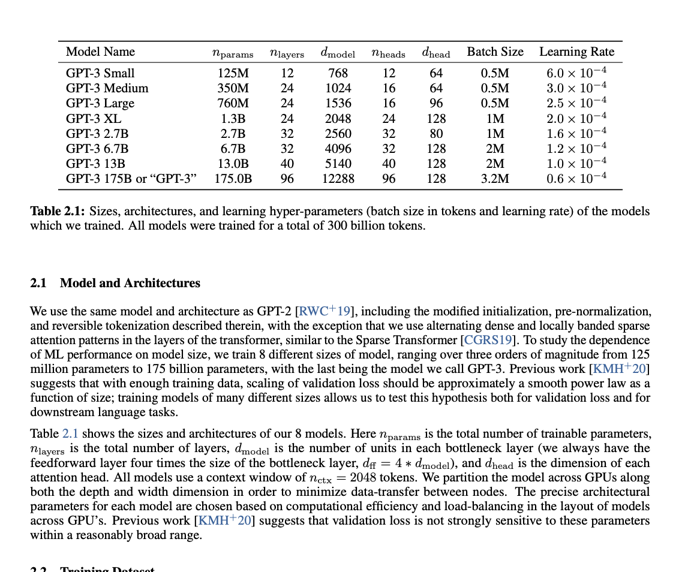

In [100]:
from PIL import Image
from huggingface_hub import hf_hub_download

# let's load an example image
file_path = hf_hub_download(repo_id="nielsr/example-pdf", repo_type="dataset", filename="image.png")
image = Image.open(file_path).convert("RGB")
# let's display it a bit smaller
width, height = image.size
display(image.resize((int(0.6*width), (int(0.6*height)))))

In [101]:
from torchvision import transforms

class MaxResize(object):
    def __init__(self, max_size=800):
        self.max_size = max_size

    def __call__(self, image):
        width, height = image.size
        current_max_size = max(width, height)
        scale = self.max_size / current_max_size
        resized_image = image.resize((int(round(scale*width)), int(round(scale*height))))

        return resized_image

detection_transform = transforms.Compose([
    MaxResize(800),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

pixel_values = detection_transform(image).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 674, 800])


In [102]:
import torch

with torch.no_grad():
    outputs = model(pixel_values)

print(outputs.logits.shape)

torch.Size([1, 15, 3])


In [103]:
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b


# update id2label to include "no object"
id2label = model.config.id2label
id2label[len(model.config.id2label)] = "no object"


def outputs_to_objects(outputs, img_size, id2label):
    m = outputs.logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs['pred_boxes'].detach().cpu()[0]
    pred_bboxes = [elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)]

    objects = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = id2label[int(label)]
        if not class_label == 'no object':
            objects.append({'label': class_label, 'score': float(score),
                            'bbox': [float(elem) for elem in bbox]})

    return objects

objects = outputs_to_objects(outputs, image.size, id2label)
print(objects)

[{'label': 'table', 'score': 0.9999570846557617, 'bbox': [110.24547576904297, 73.31171417236328, 1024.609130859375, 308.7159423828125]}]


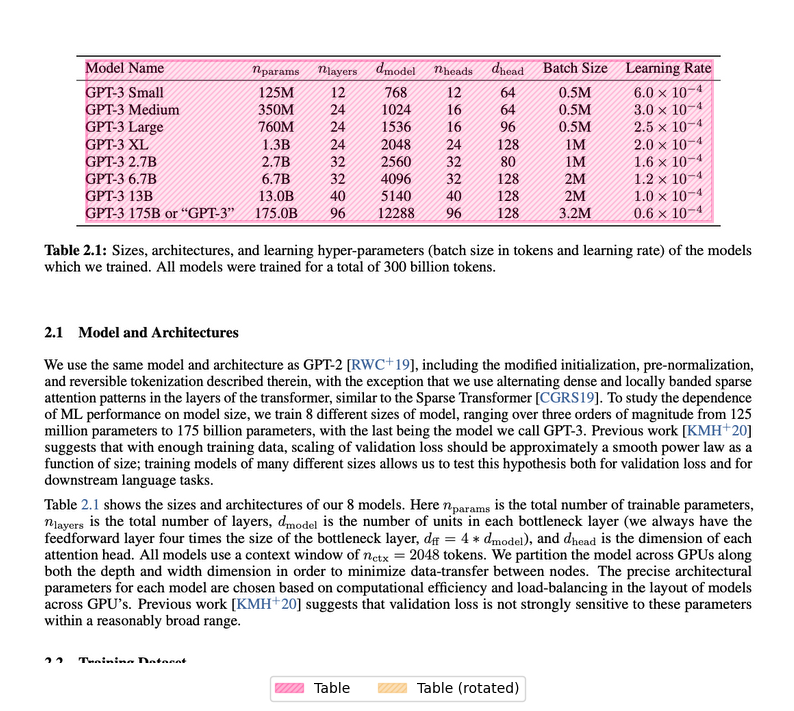

In [104]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch

def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img


def visualize_detected_tables(img, det_tables, out_path=None):
    plt.imshow(img, interpolation="lanczos")
    fig = plt.gcf()
    fig.set_size_inches(20, 20)
    ax = plt.gca()

    for det_table in det_tables:
        bbox = det_table['bbox']

        if det_table['label'] == 'table':
            facecolor = (1, 0, 0.45)
            edgecolor = (1, 0, 0.45)
            alpha = 0.3
            linewidth = 2
            hatch='//////'
        elif det_table['label'] == 'table rotated':
            facecolor = (0.95, 0.6, 0.1)
            edgecolor = (0.95, 0.6, 0.1)
            alpha = 0.3
            linewidth = 2
            hatch='//////'
        else:
            continue

        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=linewidth,
                                    edgecolor='none',facecolor=facecolor, alpha=0.1)
        ax.add_patch(rect)
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=linewidth,
                                    edgecolor=edgecolor,facecolor='none',linestyle='-', alpha=alpha)
        ax.add_patch(rect)
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=0,
                                    edgecolor=edgecolor,facecolor='none',linestyle='-', hatch=hatch, alpha=0.2)
        ax.add_patch(rect)

    plt.xticks([], [])
    plt.yticks([], [])

    legend_elements = [Patch(facecolor=(1, 0, 0.45), edgecolor=(1, 0, 0.45),
                                label='Table', hatch='//////', alpha=0.3),
                        Patch(facecolor=(0.95, 0.6, 0.1), edgecolor=(0.95, 0.6, 0.1),
                                label='Table (rotated)', hatch='//////', alpha=0.3)]
    plt.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.02), loc='upper center', borderaxespad=0,
                    fontsize=10, ncol=2)
    plt.gcf().set_size_inches(10, 10)
    plt.axis('off')

    if out_path is not None:
        plt.savefig(out_path, bbox_inches='tight', dpi=150)

    return fig

fig = visualize_detected_tables(image, objects)
visualized_image = fig2img(fig)

## Table Structure Detection

### Crop table
Next, we crop the table out of the image. For that, the TATR authors employ some padding to make sure the borders of the table are included.

In [105]:
def objects_to_crops(img, tokens, objects, class_thresholds, padding=10):
    """
    Process the bounding boxes produced by the table detection model into
    cropped table images and cropped tokens.
    """

    table_crops = []
    for obj in objects:
        if obj['score'] < class_thresholds[obj['label']]:
            continue

        cropped_table = {}

        bbox = obj['bbox']
        bbox = [bbox[0]-padding, bbox[1]-padding, bbox[2]+padding, bbox[3]+padding]

        cropped_img = img.crop(bbox)

        table_tokens = [token for token in tokens if iob(token['bbox'], bbox) >= 0.5]
        for token in table_tokens:
            token['bbox'] = [token['bbox'][0]-bbox[0],
                             token['bbox'][1]-bbox[1],
                             token['bbox'][2]-bbox[0],
                             token['bbox'][3]-bbox[1]]

        # If table is predicted to be rotated, rotate cropped image and tokens/words:
        if obj['label'] == 'table rotated':
            cropped_img = cropped_img.rotate(270, expand=True)
            for token in table_tokens:
                bbox = token['bbox']
                bbox = [cropped_img.size[0]-bbox[3]-1,
                        bbox[0],
                        cropped_img.size[0]-bbox[1]-1,
                        bbox[2]]
                token['bbox'] = bbox

        cropped_table['image'] = cropped_img
        cropped_table['tokens'] = table_tokens

        table_crops.append(cropped_table)

    return table_crops

In [106]:
objects

[{'label': 'table',
  'score': 0.9999570846557617,
  'bbox': [110.24547576904297,
   73.31171417236328,
   1024.609130859375,
   308.7159423828125]}]

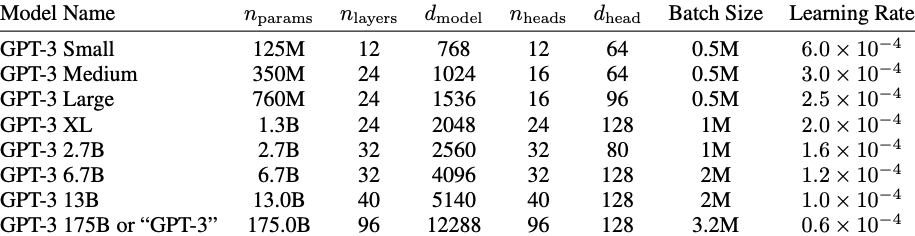

In [107]:
tokens = []
detection_class_thresholds = {
    "table": 0.5,
    "table rotated": 0.5,
    "no object": 10
}
crop_padding = 10

tables_crops = objects_to_crops(image, tokens, objects, detection_class_thresholds, padding=0)
cropped_table = tables_crops[0]['image'].convert("RGB")
cropped_table

### Load structure recognition model
Next, we load a Table Transformer pre-trained for table structure recognition.

In [108]:
device

'cuda'

In [109]:
from transformers import TableTransformerForObjectDetection

# new v1.1 checkpoints require no timm anymore
structure_model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-structure-recognition-v1.1-all")
structure_model.to(device)
print("")

We prepare the cropped table image for the model, and perform a forward pass.

In [110]:
structure_transform = transforms.Compose([
    MaxResize(1000),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [111]:
pixel_values = structure_transform(cropped_table).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 258, 1000])


In [112]:
# forward pass
with torch.no_grad():
    outputs = structure_model(pixel_values)

In [113]:
# update id2label to include "no object"
structure_id2label = structure_model.config.id2label
structure_id2label[len(structure_id2label)] = "no object"

cells = outputs_to_objects(outputs, cropped_table.size, structure_id2label)
print(cells)

[{'label': 'table column', 'score': 0.9998770952224731, 'bbox': [230.5039520263672, 0.556365966796875, 326.9322814941406, 235.61924743652344]}, {'label': 'table row', 'score': 0.9972992539405823, 'bbox': [0.06015568971633911, 85.75882720947266, 914.5903930664062, 111.19857788085938]}, {'label': 'table column', 'score': 0.9999209642410278, 'bbox': [654.2432250976562, 0.5271775722503662, 775.5479736328125, 235.58642578125]}, {'label': 'table column', 'score': 0.9996966123580933, 'bbox': [497.470703125, 0.48783302307128906, 580.6917114257812, 235.5598602294922]}, {'label': 'table column', 'score': 0.9998165965080261, 'bbox': [580.8551635742188, 0.4794985055923462, 654.0557250976562, 235.55372619628906]}, {'label': 'table row', 'score': 0.9960986375808716, 'bbox': [-0.04886627197265625, 30.436616897583008, 914.5077514648438, 60.482666015625]}, {'label': 'table column', 'score': 0.9999258518218994, 'bbox': [775.594482421875, 0.5367569923400879, 914.6141357421875, 235.63446044921875]}, {'lab

## Visualize cells
- We can visualize all recognized cells using PIL's ImageDraw module.

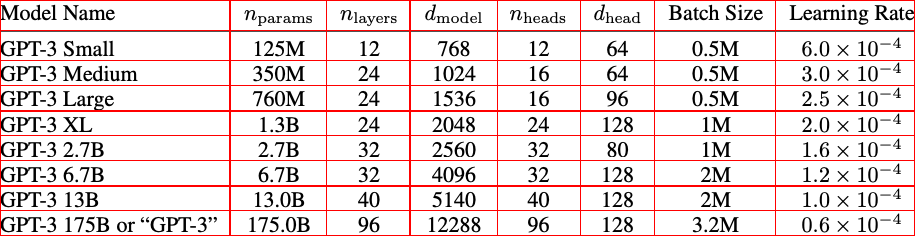

In [114]:
from PIL import ImageDraw

cropped_table_visualized = cropped_table.copy()
draw = ImageDraw.Draw(cropped_table_visualized)

for cell in cells:
    draw.rectangle(cell["bbox"], outline="red")

cropped_table_visualized

In [115]:
def plot_results(cells, class_to_visualize):
    if class_to_visualize not in structure_model.config.id2label.values():
        raise ValueError("Class should be one of the available classes")

    plt.figure(figsize=(16,10))
    plt.imshow(cropped_table)
    ax = plt.gca()

    for cell in cells:
        score = cell["score"]
        bbox = cell["bbox"]
        label = cell["label"]

        if label == class_to_visualize:
            xmin, ymin, xmax, ymax = tuple(bbox)

            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color="red", linewidth=3))
            text = f'{cell["label"]}: {score:0.2f}'
            ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
            plt.axis('off')

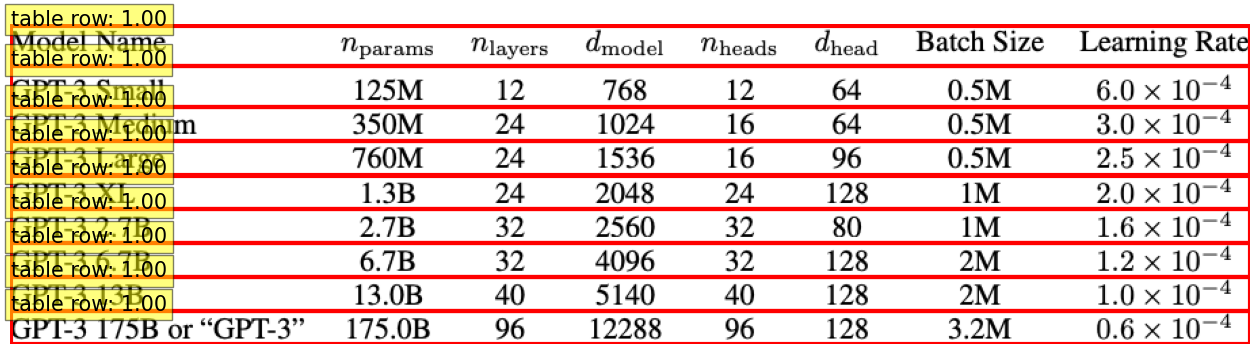

In [116]:
plot_results(cells, class_to_visualize="table row")

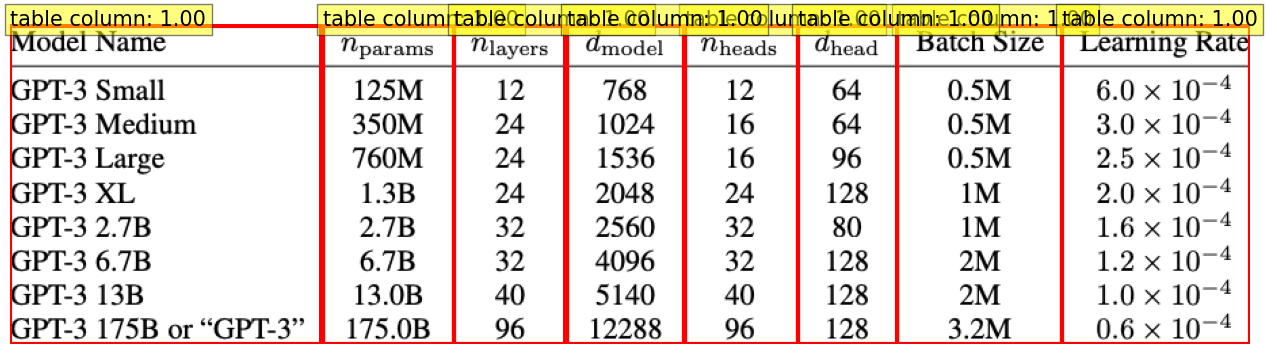

In [117]:
plot_results(cells, class_to_visualize="table column")

## Apply OCR row by row

First, we get the coordinates of the individual cells, row by row, by looking at the intersection of the table rows and columns (thanks ChatGPT!).

Next, we apply OCR on each individual cell, row-by-row.

Note that this makes some assumptions about the structure of the table: it assumes that the table has a rectangular, flat structure, containing a column header. One would need to update this for more complex table structures, potentially fine-tuning the detection and/or structure recognition model to be able to detect other layouts. Typically 50 labeled examples suffice for fine-tuning, but the more data you have, the better.

Alternatively, one could also do OCR column by column, etc.

In [118]:
import pytesseract
from PIL import Image, ImageDraw
import pandas as pd

# Function to get cell coordinates by row and column
def get_cell_coordinates_by_row(table_data):
    # Extract rows and columns
    rows = [entry for entry in table_data if entry['label'] == 'table row']
    columns = [entry for entry in table_data if entry['label'] == 'table column']

    # Sort rows by their Y coordinate (top to bottom)
    rows.sort(key=lambda x: x['bbox'][1])
    # Sort columns by their X coordinate (left to right)
    columns.sort(key=lambda x: x['bbox'][0])

    # Function to find cell coordinates
    def find_cell_coordinates(row, column):
        cell_bbox = [column['bbox'][0], row['bbox'][1], column['bbox'][2], row['bbox'][3]]
        return cell_bbox

    # Generate cell coordinates and count cells in each row
    cell_coordinates = []

    for row in rows:
        row_cells = []
        for column in columns:
            cell_bbox = find_cell_coordinates(row, column)
            row_cells.append({'column': column['bbox'], 'cell': cell_bbox})

        # Sort cells in the row by X coordinate
        row_cells.sort(key=lambda x: x['column'][0])

        # Append row information to cell_coordinates
        cell_coordinates.append({'row': row['bbox'], 'cells': row_cells, 'cell_count': len(row_cells)})

    # Sort rows from top to bottom
    cell_coordinates.sort(key=lambda x: x['row'][1])

    return cell_coordinates


In [119]:
cell_coordinates = get_cell_coordinates_by_row(cells)

In [120]:
#cell_coordinates

In [126]:
import numpy as np
import easyocr
import pandas as pd
from tqdm.auto import tqdm

def apply_ocr_tesseract(cell_coordinates, cropped_table):
    data = []
    max_num_columns = 0

    for idx, row in enumerate(tqdm(cell_coordinates)):
        row_text = []
        for cell in row["cells"]:
            # Crop cell out of the image
            cell_image = cropped_table.crop(cell["cell"])

            try:
                # Apply OCR using Tesseract with --psm 6
                text = pytesseract.image_to_string(cell_image, config='--psm 6').strip()
                row_text.append(text)
            except Exception as e:
                print(f"Error processing cell {cell}: {e}")
                row_text.append("")  # Append empty string if an error occurs during OCR

        num_columns = len(row_text)
        if num_columns > max_num_columns:
            max_num_columns = num_columns

        data.append(row_text)

    # Pad rows to ensure all rows have the same number of columns
    for row_idx, row_data in enumerate(data):
        if len(row_data) < max_num_columns:
            data[row_idx] += [""] * (max_num_columns - len(row_data))

    return data

In [127]:
data = apply_ocr_tesseract(cell_coordinates,cropped_table)
data

  0%|          | 0/9 [00:00<?, ?it/s]

[['Model Name',
  'Tparams',
  'Mayers',
  'dmodel',
  'heads',
  'dnead',
  'Batch Size',
  'Learning Rate'],
 ['GPT-3 Small', '125M', '12', '768', '12', '64', '0.5M', '6.0 x 10-4'],
 ['GPT-3 Medium', '350M', '24', '1024', '16', '64', '0.5M', '3.0 x 10-4'],
 ['GPT-3 Large', '760M', '24', '1536', '16', '96', '0.5M', '2.5 x= 10-4'],
 ['GPT-3 XL', '1.3B', '24', '2048', '24', '128', '1M', '2.0 x 10-4'],
 ['GPT-3 2.7B', '2.7B', '32', '2560', '32', '80', '1M', '1.6 x 107-4'],
 ['GPT-3 6.7B', '6.7B', '32', '4096', '32', '128', '2M', '1.2x 10-4'],
 ['GPT-3 13B', '13.0B', '40', '5140', '40', '128', '2M', '1.0 x 10-4'],
 ['GPT-3 175B or “GPT-3”',
  '175.0B',
  '96',
  '12288',
  '96',
  '128',
  '3.2M',
  '0.6 x 10-4']]

In [128]:
# Create a pandas dataframe from the extracted data
df = pd.DataFrame(data)

In [129]:
df

,0,1,2,3,4,5,6,7
0,Model Name,Tparams,Mayers,dmodel,heads,dnead,Batch Size,Learning Rate
1,GPT-3 Small,125M,12,768,12,64,0.5M,6.0 x 10-4
2,GPT-3 Medium,350M,24,1024,16,64,0.5M,3.0 x 10-4
3,GPT-3 Large,760M,24,1536,16,96,0.5M,2.5 x= 10-4
4,GPT-3 XL,1.3B,24,2048,24,128,1M,2.0 x 10-4
5,GPT-3 2.7B,2.7B,32,2560,32,80,1M,1.6 x 107-4
6,GPT-3 6.7B,6.7B,32,4096,32,128,2M,1.2x 10-4
7,GPT-3 13B,13.0B,40,5140,40,128,2M,1.0 x 10-4
8,GPT-3 175B or “GPT-3”,175.0B,96,12288,96,128,3.2M,0.6 x 10-4


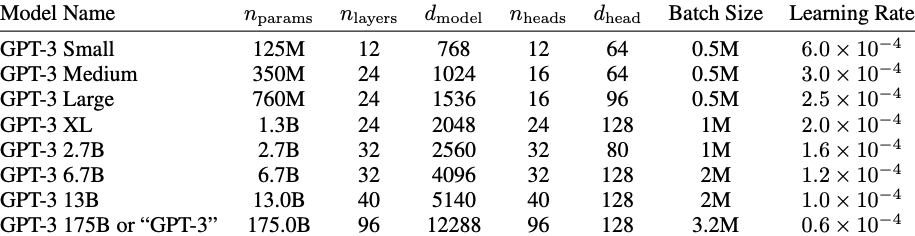

In [130]:
cropped_table